Könyvtárak importálása:


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np

Beolvassuk fájlt

In [ ]:
student_spending = pd.read_csv('xstudent_spending.csv')
student_spending



,Unnamed: 0,age,gender,year_in_school,major,monthly_income,financial_aid,tuition,housing,food,transportation,books_supplies,entertainment,personal_care,technology,health_wellness,miscellaneous,preferred_payment_method
0,0,19,Non-binary,Freshman,Psychology,958,270,5939,709,296,123,188,41,78,134,127,72,Credit/Debit Card
1,1,24,Female,Junior,Economics,1006,875,4908,557,365,85,252,74,92,226,129,68,Credit/Debit Card
2,2,24,Non-binary,Junior,Economics,734,928,3051,666,220,137,99,130,23,239,112,133,Cash
3,3,23,Female,Senior,Computer Science,617,265,4935,652,289,114,223,99,30,163,105,55,Mobile Payment App
4,4,20,Female,Senior,Computer Science,810,522,3887,825,372,168,194,48,71,88,71,104,Credit/Debit Card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,22,Female,Senior,Biology,1346,520,3688,969,152,194,151,42,38,252,65,163,Cash
996,996,19,Female,Senior,Biology,1407,560,3380,508,265,52,206,40,98,274,84,135,Mobile Payment App
997,997,20,Male,Junior,Economics,957,393,3497,723,339,139,69,112,46,284,57,28,Mobile Payment App
998,998,22,Non-binary,Senior,Economics,1174,612,3649,543,237,123,200,129,90,190,101,65,Mobile Payment App


In [ ]:
#átalakítjuk az oszlopunk értékeit hogy tudjunk vele dologzni
student_spending["preferred_payment_method"] = student_spending["preferred_payment_method"].str.replace('Cash', '0')
student_spending["preferred_payment_method"] = student_spending["preferred_payment_method"].str.replace('Credit/Debit Card', '1')
student_spending["preferred_payment_method"] = student_spending["preferred_payment_method"].str.replace('Mobile Payment App', '2')
student_spending["preferred_payment_method"] = student_spending["preferred_payment_method"].astype(float)
student_spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   age                       1000 non-null   int64  
 2   gender                    1000 non-null   object 
 3   year_in_school            1000 non-null   object 
 4   major                     1000 non-null   object 
 5   monthly_income            1000 non-null   int64  
 6   financial_aid             1000 non-null   int64  
 7   tuition                   1000 non-null   int64  
 8   housing                   1000 non-null   int64  
 9   food                      1000 non-null   int64  
 10  transportation            1000 non-null   int64  
 11  books_supplies            1000 non-null   int64  
 12  entertainment             1000 non-null   int64  
 13  personal_care             1000 non-null   int64  
 14  technolog

In [ ]:
# Kategorikus oszlopok átalakítása numerikus értékekké
label_encoder = LabelEncoder()
student_spending['gender'] = label_encoder.fit_transform(student_spending['gender'])
student_spending['year_in_school'] = label_encoder.fit_transform(student_spending['year_in_school'])
student_spending['major'] = label_encoder.fit_transform(student_spending['major'])

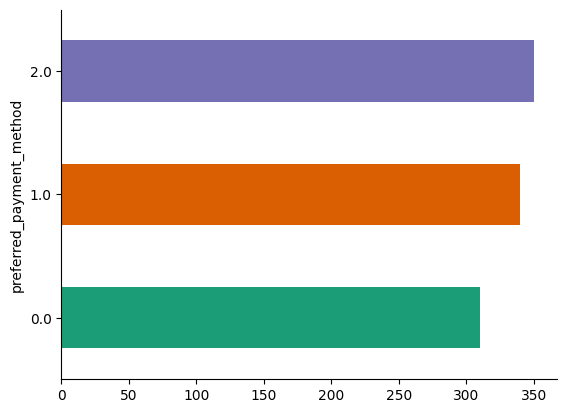

In [ ]:
# @title preferred_payment_method

from matplotlib import pyplot as plt
import seaborn as sns
student_spending.groupby('preferred_payment_method').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Az alábbi diagrammon, lláthatjuk, hogy hasonló számban oszlanak el a fizetési szokások.

In [ ]:
#Kidobjuk azokat a sorokat, ahol duplikált az érték.
student_spending=student_spending.drop_duplicates()
print('Shape After deleting duplicate values:', student_spending.shape)

Shape After deleting duplicate values: (1000, 18)


In [ ]:
#Kidobjuk azokat a sorokat, ahol nincs érték.
student_spending.dropna(inplace=True)
print('Shape After deleting missing values:', student_spending.shape)

Shape After deleting missing values: (1000, 18)


### **A modell tanítása**

In [ ]:
# ez a függvény a modell teljesítményét adja vissza (accuracy, classification report és confusion matrix)
def model_performance(y_test,y_pred, method):

    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")

    #generate the classification report
    print(classification_report(y_test,y_pred))

    #generate the confusion matrix

    cnf_matrix_log = confusion_matrix(y_test, y_pred)

    print(cnf_matrix_log)

In [ ]:
# Felosztás tanító és teszt adatokra
X = student_spending.drop(['preferred_payment_method'], axis=1)  # Független változók
y = student_spending['preferred_payment_method']  # Célváltozó
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Döntési fa osztályozó modell

In [ ]:
# Döntési fa osztályozó modell létrehozása és tanítása
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Amikor az algoritmus véletlenszerű döntéseket hoz, például az adatok megosztása a tanító- és tesztadatok között, vagy a fa csomópontjainak kiválasztása, a random_state beállítása garantálja, hogy ugyanazokat a véletlenszerű eredményeket kapjuk minden egyes futásnál. Ez kiszámíthatóvá és reprodukálhatóvá teszi az eredményeket.

In [ ]:
# Tesztelés a modell pontosságának ellenőrzésére
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Pontosság:", accuracy)

Pontosság: 0.355


In [ ]:
# Osztályozási jelentés és konfúziós mátrix
print("\nOsztályozási jelentés:")
print(classification_report(y_test, y_pred))

print("\nKonfúziós mátrix:")
print(confusion_matrix(y_test, y_pred))


Osztályozási jelentés:
              precision    recall  f1-score   support

         0.0       0.27      0.25      0.26        59
         1.0       0.39      0.38      0.38        74
         2.0       0.39      0.42      0.40        67

    accuracy                           0.36       200
   macro avg       0.35      0.35      0.35       200
weighted avg       0.35      0.35      0.35       200


Konfúziós mátrix:
[[15 25 19]
 [21 28 25]
 [20 19 28]]


2. **Random forest** osztályozó modell



In [ ]:
# paraméterezés
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50,max_leaf_nodes = 30)
# fitting the model
model_rf.fit(X_train, y_train)

# make predictions
prediction_test = model_rf.predict(X_test)

In [ ]:
# a modell teljesítményének értékelés
model_performance(y_test,prediction_test, 'Random Forest')

Accuracy score of the model 0.37
Classification report 

              precision    recall  f1-score   support

         0.0       0.28      0.14      0.18        59
         1.0       0.42      0.39      0.41        74
         2.0       0.36      0.55      0.44        67

    accuracy                           0.37       200
   macro avg       0.35      0.36      0.34       200
weighted avg       0.36      0.37      0.35       200

[[ 8 20 31]
 [11 29 34]
 [10 20 37]]


A modellek értékelésére és finomhangolására keresztezéses validációt használhatunk, hogy objektíven értékelhessük a modellek teljesítményét

In [ ]:
# keresztvalidáció
from sklearn.model_selection import RepeatedStratifiedKFold
# apply k-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.367 (0.050)


Modell hangolása A RandomForest osztályozó teljesítményének optimalizálásához a különböző hiperparaméterek értékein un. rácsos keresést alkalmazhatunk. A hiperparaméter-értékek különböző kombinációinak szisztematikus vizsgálatával megtalálhatjuk azt a konfigurációt, amely javítja a modell előrejelző képességeit. Ez a folyamat lehetővé teszi számunkra a RandomForest osztályozó finomhangolását és a paraméterbeállítások optimális egyensúlyának elérését, ami végső soron javítja az általános pontosságát és robusztusságát.
A GridSearchCV segítségével megadhatjuk ezeket a lehetséges értékeket, és a GridSearchCV végigpróbál minden lehetséges kombinációt, majd megtalálja a legjobbat.

In [ ]:
# a paraméter rács randomizált kialakítása
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'n_estimators': [200, 500],
    'max_leaf_nodes' : [20, 30]
}

# A grid search modell indítása
grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_leaf_nodes=30,
                                              n_estimators=500, n_jobs=-1,
                                              oob_score=True, random_state=50),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90],
                         'max_leaf_nodes': [20, 30],
                         'n_estimators': [200, 500]},
             verbose=2)

In [ ]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 20, 'n_estimators': 200}

Feature Importance Scores (változók fontossága)
A Random Forest a jellemző fontosságát annak értékelésével számítják ki, hogy az egyes jellemzők mennyire járulnak hozzá a keveredés (osztályozásban) vagy a hiba (regresszióban) csökkentéséhez, amikor a döntési fák együttesén belüli felosztási kritériumként használják őket. Azokat a jellemzőket, amelyek következetesen tisztább csomópontokhoz vagy alacsonyabb hibához vezetnek, fontosabbnak tekintik, és a jellemzők kiválasztásának alapjául szolgálnak.

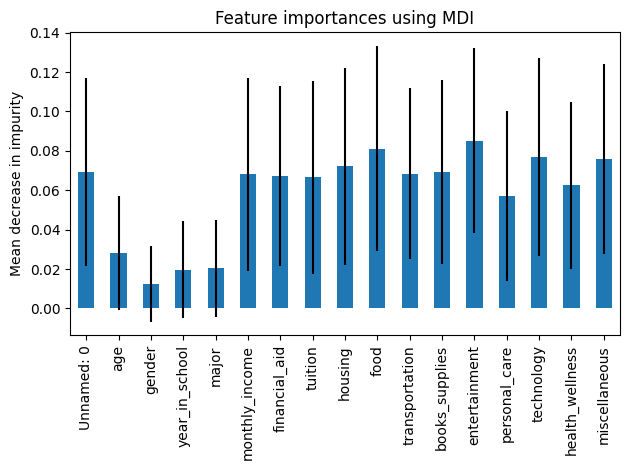

In [ ]:
forest_importances = pd.Series(model_rf.feature_importances_, index=X.columns.values)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

A legfontosabb változók:
1.   food
2.   entertainment
3.   technology
4.   miscellaneous

3. XGBOOST

Extreme Gradient Boosting, erőteljes gépi tanuló algortimus, amely klasszifikációs és regressziós feladatokra is használható. Az algoritmus alpja a döntési fa módszer, az XGBoost több un. gyenge tanuló algortimust épít fel, és ezekkel folyamatosan javítja modell pontosságát. Megvizsgáljuk, hogy az XGBOOST jobb eredményt ad-e, mint a Random Forest.

In [ ]:
# A változók sztenderdizálása
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# egydimenziós vektorrá alakítás
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

# Az XGBClassifier importja
from xgboost import XGBClassifier

# A modell tanítása
model_xgb = XGBClassifier(learning_rate=0.01,
                            n_estimators=50,
                            max_depth=6,
                            random_state=42,
                            n_jobs=-1)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)

In [ ]:
model_performance(y_test,y_pred, 'XGBoost')

Accuracy score of the model 0.34
Classification report 

              precision    recall  f1-score   support

         0.0       0.22      0.19      0.20        59
         1.0       0.43      0.39      0.41        74
         2.0       0.34      0.42      0.38        67

    accuracy                           0.34       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.34      0.34      0.34       200

[[11 21 27]
 [18 29 27]
 [21 18 28]]


 Nincs javulás a Random  foresthez képest.

In [ ]:
# gridsearch
# grid search for the XGBClassifier
clf = GridSearchCV(
        model_xgb,
        {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200]},
        verbose=1,
        n_jobs=2,
    )
clf.fit(X_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.35875
{'max_depth': 2, 'n_estimators': 200}


Mivel a célváltozó több mint két osztályból áll (többosztályos probléma), és az ROC AUC (Receiver Operating Characteristic Area Under the Curve) érték csak bináris osztályozásra használható. Az ROC AUC számítása olyan problémákra van tervezve, ahol csak két osztály van.

Ha a célváltozóm többosztályos, akkor más értékelési metrikát kell használni a keresztvalidáció során. Például az egyik lehetőség a accuracy, ami az osztályozási pontosságot méri.

In [ ]:
# Az "preferred_payment_method" oszlop értékeinek átalakítása binárisra
student_spending["preferred_payment_method"] = (student_spending["preferred_payment_method"] == "Cash").astype(int)

# Átalakított adatok ellenőrzése
#print(student_spending.head())

from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier

# XGBoost osztály definiálása
model_xgb = XGBClassifier(objective="binary:logistic", colsample_bytree=0.3, learning_rate=0.1,
                           max_depth=5, alpha=10)

# Keresztvalidáció
scores = cross_val_score(model_xgb, X, y, cv=3, scoring='accuracy')

# Eredmények kiírása
print("Pontosság átlagos értéke:", scores.mean())

Pontosság átlagos értéke: 0.3389826952701204



# **Következtetés**:

A vizsgált adatokon végzett modellezés során több algoritmust is kipróbáltam, köztük a Döntési Fa, Random Forest és XGBoost modelleket. Az eredmények alapján mindhárom modell hasonló pontosságot mutatott, körülbelül 33-37% körüli értéket. Az adatok előfeldolgozása és a hiperparaméterek hangolása sem vezetett jelentős javuláshoz a modell teljesítményében.

A feature importance elemzés során megfigyelhető, hogy az étel, szórakozás, technológia és egyéb kiadások jelentős befolyással bírnak a preferált fizetési módszerre. Ezek az eredmények érthetőek és életképesek lehetnek egy diák szempontjából, és arra utalnak, hogy a modellünk megfelelően figyelembe veszi ezeket a tényezőket.

Az eddigi eredmények alapján a jelenlegi modellek még nem rendelkeznek elég pontos előrejelzéssel a preferált fizetési módszer meghatározására.